In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

In [ ]:
# Load EEG data from CSV file
csv_file_path = '/content/Epileptic Seizure Recognition.csv'  # Replace with the actual path to your EEG data CSV file
eeg_data = pd.read_csv(csv_file_path)

In [ ]:
print(eeg_data.keys())

Index(['Unnamed', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       ...
       'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178',
       'y'],
      dtype='object', length=180)


In [ ]:
X = eeg_data.iloc[:, 1:-1].values

In [ ]:
print(X)
X.shape

[[ 135  190  229 ... -116  -83  -51]
 [ 386  382  356 ...  154  143  129]
 [ -32  -39  -47 ...  -35  -35  -36]
 ...
 [  14    6  -13 ...   -2   -1   -8]
 [ -40  -25   -9 ...   68   59   55]
 [  29   41   57 ...   -2    2   20]]


(11500, 178)

In [ ]:
y = eeg_data.iloc[:,-1:].values

In [ ]:
y.shape

(11500, 1)

In [ ]:
num_classes = len(np.unique(y))

In [ ]:
print(y)

[[4]
 [1]
 [5]
 ...
 [5]
 [3]
 [4]]


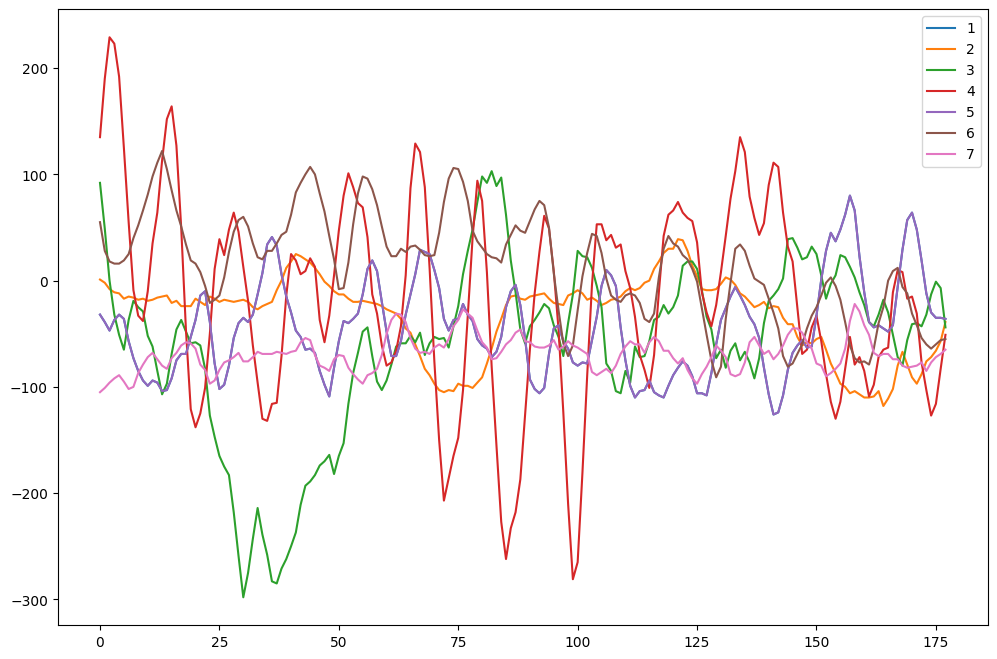

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(X[2,:],label='1')
plt.plot(X[7,:],label='2')
plt.plot(X[12,:],label='3')
plt.plot(X[0,:],label='4')
plt.plot(X[2,:],label='5')
plt.plot(X[5,:],label='6')
plt.plot(X[3,:],label='7')
plt.legend()
plt.show()

In [ ]:
# Create an empty array to store the magnitude spectrum
magnitude_spectrum = np.zeros_like(X, dtype=np.float64)

In [ ]:
for i in range(len(X)):
    row_vector = X[i, :]
    fft_result = np.fft.fft(row_vector)
    #fft_results[i,:] = fft_result
    magnitude_spectrum[i,:] = np.abs(fft_result)

In [ ]:
magnitude_spectrum.shape

(11500, 178)

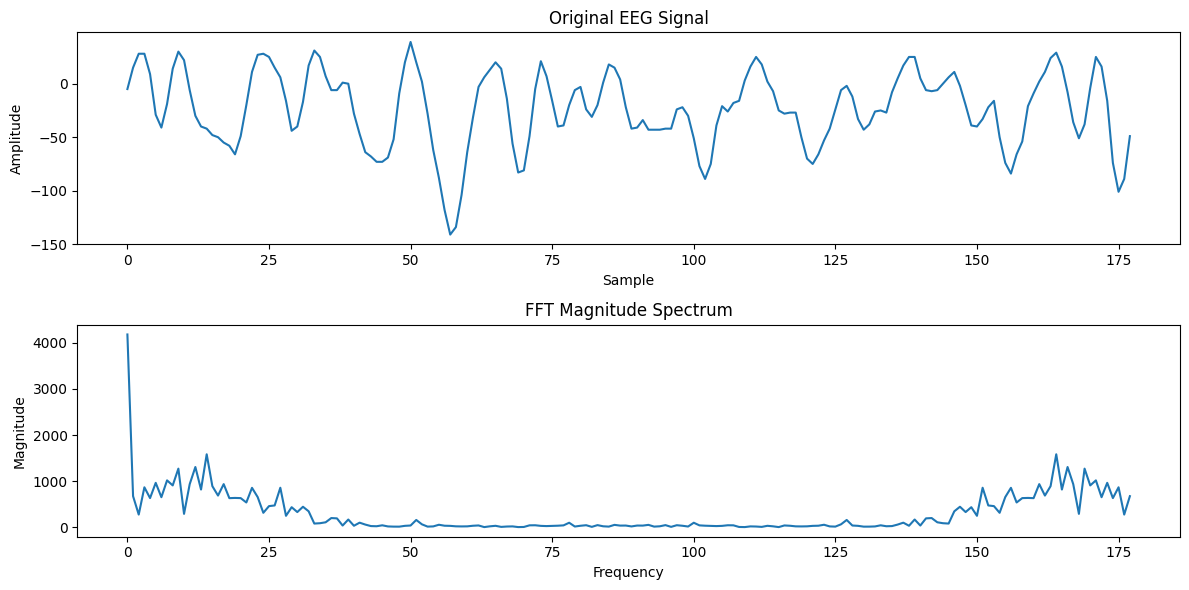

In [ ]:
# Plot the original signal and its FFT
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(X[10,:],label='1')
plt.title('Original EEG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(magnitude_spectrum[10,:], label=1)
plt.title('FFT Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(magnitude_spectrum,y,test_size=0.25,shuffle=True)
X_train.shape,y_test.shape

((8625, 178), (2875, 1))

In [ ]:
# Reshape the data to comply with the 3D input shape expected by Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
X_train.shape,X_test.shape

((8625, 178, 1), (2875, 178, 1))

In [ ]:
y_train=y_train-1
y_test = y_test -1

In [ ]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features):
        score = tf.nn.tanh(self.W(features))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        return context_vector

# Define the 1D RNN model with attention
model = models.Sequential()

# Define the 1D CNN model with attention
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(178, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.GlobalAveragePooling1D())  # GlobalAveragePooling1D instead of Flatten

# Add Reshape layer to ensure compatibility with Dense layer
model.add(layers.Reshape((-1, 64)))

# Add attention layer
model.add(AttentionLayer(64))

# Add remaining LSTM layers
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32))  # Last LSTM layer without return_sequences=True

# Add Dense layers
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 176, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 88, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 86, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 43, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 64)            12352     
                                                                 
 global_average_pooling1d (  (None, 64)                0

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
270/270 [==============================] - 8s 15ms/step - loss: 1.2340 - accuracy: 0.4356 - val_loss: 0.9103 - val_accuracy: 0.5976
Epoch 2/5
270/270 [==============================] - 4s 13ms/step - loss: 0.7280 - accuracy: 0.6633 - val_loss: 0.6990 - val_accuracy: 0.6525
Epoch 3/5
270/270 [==============================] - 4s 13ms/step - loss: 0.6202 - accuracy: 0.6979 - val_loss: 0.6218 - val_accuracy: 0.7061
Epoch 4/5
270/270 [==============================] - 3s 12ms/step - loss: 0.5771 - accuracy: 0.7202 - val_loss: 0.6157 - val_accuracy: 0.7162
Epoch 5/5
270/270 [==============================] - 4s 13ms/step - loss: 0.5670 - accuracy: 0.7340 - val_loss: 0.5826 - val_accuracy: 0.7256


In [ ]:
# Assuming you have trained your model and stored it in the variable 'model'

# Extract the weights of the dense layer before softmax activation
dense_layer_weights = model.layers[-2].get_weights()[0]

# Transpose the weights to obtain the precision matrix
precision_matrix = dense_layer_weights.T

print("Precision Matrix Shape:", precision_matrix.shape)
print("Precision Matrix:", precision_matrix)

Precision Matrix Shape: (32, 32)
Precision Matrix: [[ 0.23601972  0.10113461 -0.33490664 ... -0.13894151 -0.02017812
   0.01180877]
 [-0.15938903  0.04276609  0.10125787 ... -0.09770996  0.18341637
   0.20956436]
 [-0.02051967 -0.09923332  0.0022282  ...  0.01704135 -0.12686029
   0.16522858]
 ...
 [-0.30951154  0.19744915  0.25728408 ... -0.19272833 -0.03545809
  -0.03785321]
 [ 0.17113572 -0.1613177   0.20904738 ... -0.22625273  0.17506957
   0.18678631]
 [ 0.14409728 -0.1473292   0.14790414 ... -0.28531513 -0.22579376
  -0.0080613 ]]


Epoch 1/70
270/270 [==============================] - 3s 11ms/step - loss: 0.5525 - accuracy: 0.7388 - val_loss: 0.5608 - val_accuracy: 0.7593
Epoch 2/70
270/270 [==============================] - 4s 14ms/step - loss: 0.5367 - accuracy: 0.7477 - val_loss: 0.6027 - val_accuracy: 0.7235
Epoch 3/70
270/270 [==============================] - 3s 11ms/step - loss: 0.5189 - accuracy: 0.7586 - val_loss: 0.6272 - val_accuracy: 0.7158
Epoch 4/70
270/270 [==============================] - 3s 13ms/step - loss: 0.5054 - accuracy: 0.7636 - val_loss: 0.6473 - val_accuracy: 0.6877
Epoch 5/70
270/270 [==============================] - 3s 11ms/step - loss: 0.4935 - accuracy: 0.7709 - val_loss: 0.5364 - val_accuracy: 0.7617
Epoch 6/70
270/270 [==============================] - 4s 14ms/step - loss: 0.4898 - accuracy: 0.7715 - val_loss: 0.5556 - val_accuracy: 0.7586
Epoch 7/70
270/270 [==============================] - 3s 11ms/step - loss: 0.4821 - accuracy: 0.7755 - val_loss: 0.5541 - val_accuracy: 0.7652

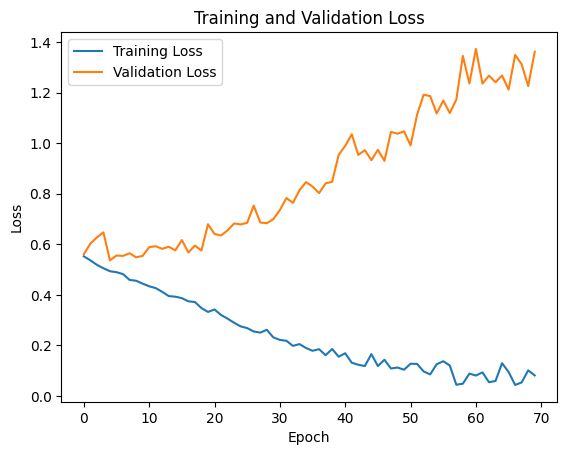

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and stored the history object
history = model.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have your test data and true labels stored in test_data and true_labels respectively

# Assuming you have already compiled and trained your model and you have predictions stored in predicted_labels
# If not, you need to make predictions on your test data
predicted_labels = model.predict(X_test)

# Convert predicted labels to class indices (assuming one-hot encoded labels)
predicted_indices = np.argmax(predicted_labels, axis=1)

# Convert true labels to class indices (assuming one-hot encoded labels)
true_indices = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_indices, predicted_indices)

print("Confusion Matrix:")
print(conf_matrix)

90/90 [==============================] - 1s 3ms/step
Confusion Matrix:
[[531  36   6  13   0]
 [  7 357 176   6  27]
 [ 10 187 370   7  37]
 [  1  13   5 382 146]
 [  0  29  18  50 461]]


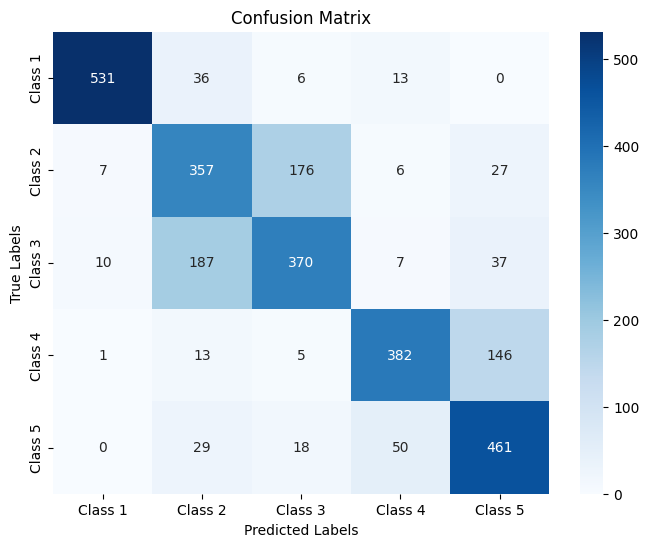

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already computed the confusion matrix as described in the previous code snippet

# Define class labels
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### dwt

In [ ]:
pip install pywavelets

In [ ]:
import pywt

In [ ]:
# Choose a wavelet and level for the DWT
wavelet = 'db1'  # Replace with the desired wavelet
level = 5  # Replace with the desired level

In [ ]:
# Create an empty array to store the DWT coefficients
dwt_coefficients = np.zeros_like(X, dtype=np.float64)

In [ ]:
dwt_coefficients = np.zeros((len(X), 181))

In [ ]:
dwt_coefficients.shape

(11500, 181)

In [ ]:
print(dwt_coefficients)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Perform DWT using a for loop
for i in range(len(X)):
    row_vector = X[i, :]
    coeffs = pywt.wavedec(row_vector, wavelet, level=level)
    dwt_coefficients[i,:] = np.concatenate(coeffs)

In [ ]:
print(dwt_coefficients)

[[ 2.48901587e+02 -1.12606755e+02 -3.23324576e+02 ...  1.83847763e+01
  -7.77817459e+00 -2.26274170e+01]
 [-6.94732413e+01  6.00156881e+02  8.98202389e+02 ... -3.53553391e+00
   1.41421356e+00  9.89949494e+00]
 [-3.55674711e+02 -1.91449161e+02 -2.13546248e+02 ...  2.19203102e+01
   3.53553391e+00  7.07106781e-01]
 ...
 [ 2.02409316e+02  1.00055610e+02  4.08354166e+01 ...  3.53553391e+00
  -1.97989899e+01  4.94974747e+00]
 [-2.96631295e+02 -2.59861742e+02 -2.73296771e+02 ...  1.90918831e+01
   1.27279221e+01  2.82842712e+00]
 [ 1.37885822e+02 -1.59275802e+02 -7.68978625e+01 ... -2.12132034e+00
   4.24264069e+00 -1.27279221e+01]]


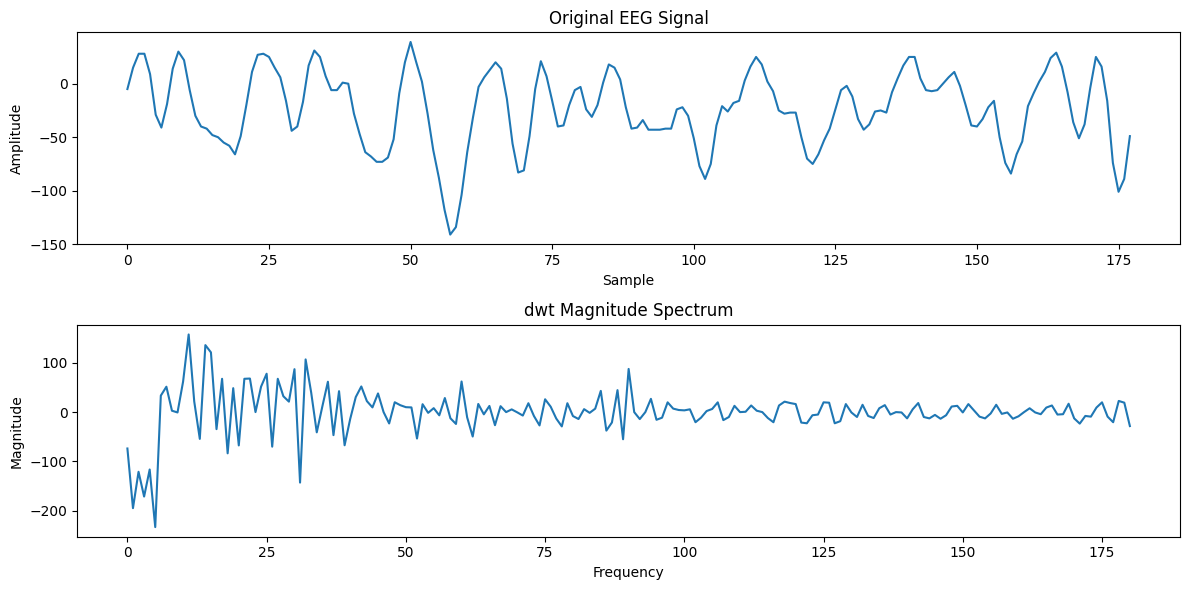

In [ ]:
# Plot the original signal and its FFT
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(X[10,:],label='1')
plt.title('Original EEG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(dwt_coefficients[10,:], label=1)
plt.title('dwt Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [ ]:
# Assuming tensor1 and tensor2 are your tensors of shape (11500, 178) and (11500, 181)
tensor1 = X
tensor2 = dwt_coefficients

# Determine the maximum number of columns
max_columns = max(tensor1.shape[1], tensor2.shape[1])

# Pad the tensors with zeros to make them have the same number of columns
padded_tensor1 = np.pad(tensor1, ((0, 0), (0, max_columns - tensor1.shape[1])))
padded_tensor2 = np.pad(tensor2, ((0, 0), (0, max_columns - tensor2.shape[1])))

# Now, you can add the padded tensors
result_tensor = padded_tensor1 + padded_tensor2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(result_tensor,y,test_size=0.25,shuffle=True)
X_train.shape,y_test.shape

In [ ]:
# Reshape the data to comply with the 3D input shape expected by Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
y_train=y_train-1
y_test = y_test -1

In [ ]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features):
        score = tf.nn.tanh(self.W(features))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        return context_vector

# Define the 1D RNN model with attention
model = models.Sequential()

# Define the 1D CNN model with attention
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(181, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.GlobalAveragePooling1D())  # GlobalAveragePooling1D instead of Flatten

# Add Reshape layer to ensure compatibility with Dense layer
model.add(layers.Reshape((-1, 64)))

# Add attention layer
model.add(AttentionLayer(64))

# Add remaining LSTM layers
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32))  # Last LSTM layer without return_sequences=True

# Add Dense layers
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 179, 32)           128       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 89, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 87, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 43, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 41, 64)            12352     
                                                                 
 global_average_pooling1d_2  (None, 64)               

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
270/270 [==============================] - 8s 15ms/step - loss: 1.1120 - accuracy: 0.5125 - val_loss: 0.7306 - val_accuracy: 0.6570
Epoch 2/50
270/270 [==============================] - 3s 12ms/step - loss: 0.6998 - accuracy: 0.6686 - val_loss: 0.6365 - val_accuracy: 0.6953
Epoch 3/50
270/270 [==============================] - 4s 14ms/step - loss: 0.6593 - accuracy: 0.6860 - val_loss: 0.6434 - val_accuracy: 0.6963
Epoch 4/50
270/270 [==============================] - 3s 12ms/step - loss: 0.6316 - accuracy: 0.6950 - val_loss: 0.6484 - val_accuracy: 0.6894
Epoch 5/50
270/270 [==============================] - 3s 13ms/step - loss: 0.6186 - accuracy: 0.6986 - val_loss: 0.6051 - val_accuracy: 0.7141
Epoch 6/50
270/270 [==============================] - 3s 12ms/step - loss: 0.6018 - accuracy: 0.7077 - val_loss: 0.6252 - val_accuracy: 0.7026
Epoch 7/50
270/270 [==============================] - 4s 13ms/step - loss: 0.5854 - accuracy: 0.7158 - val_loss: 0.6177 - val_accuracy: 0.7117

In [ ]:
model.evaluate(X_test,y_test)

90/90 [==============================] - 1s 5ms/step - loss: 2.3499 - accuracy: 0.7443


[2.349926233291626, 0.7443478107452393]

In [ ]:
# Assuming you have trained your model and stored it in the variable 'model'

# Extract the weights of the dense layer before softmax activation
dense_layer_weights = model.layers[-2].get_weights()[0]

# Transpose the weights to obtain the precision matrix
precision_matrix = dense_layer_weights.T

print("Precision Matrix Shape:", precision_matrix.shape)
print("Precision Matrix:", precision_matrix)

Precision Matrix Shape: (32, 32)
Precision Matrix: [[-0.06933996 -0.5478744  -0.15917945 ... -0.18595906 -0.26033276
   0.30369747]
 [-0.15409562  0.51083803  0.23988247 ...  0.9788847   0.07729273
   0.018531  ]
 [-0.00963693 -0.04123005 -0.13249074 ...  0.7305302  -0.3077818
   0.15622891]
 ...
 [-0.0678314  -0.09335365 -0.18702498 ... -0.4985872   0.14439647
  -0.23114228]
 [-0.77706873  0.48222432  0.37715203 ...  0.4093982  -0.0247965
   0.44340053]
 [ 0.7024573  -0.30395213 -0.06493523 ...  0.20943365  0.4912685
   0.13965878]]


Epoch 1/70
270/270 [==============================] - 3s 12ms/step - loss: 0.0811 - accuracy: 0.9711 - val_loss: 1.2854 - val_accuracy: 0.7311
Epoch 2/70
270/270 [==============================] - 4s 15ms/step - loss: 0.1090 - accuracy: 0.9599 - val_loss: 1.2792 - val_accuracy: 0.7252
Epoch 3/70
270/270 [==============================] - 3s 13ms/step - loss: 0.0843 - accuracy: 0.9700 - val_loss: 1.3373 - val_accuracy: 0.7325
Epoch 4/70
270/270 [==============================] - 3s 12ms/step - loss: 0.0921 - accuracy: 0.9668 - val_loss: 1.2114 - val_accuracy: 0.7395
Epoch 5/70
270/270 [==============================] - 4s 13ms/step - loss: 0.0787 - accuracy: 0.9702 - val_loss: 1.3190 - val_accuracy: 0.7360
Epoch 6/70
270/270 [==============================] - 4s 13ms/step - loss: 0.0963 - accuracy: 0.9652 - val_loss: 1.3159 - val_accuracy: 0.7273
Epoch 7/70
270/270 [==============================] - 3s 12ms/step - loss: 0.0909 - accuracy: 0.9677 - val_loss: 1.2676 - val_accuracy: 0.7433

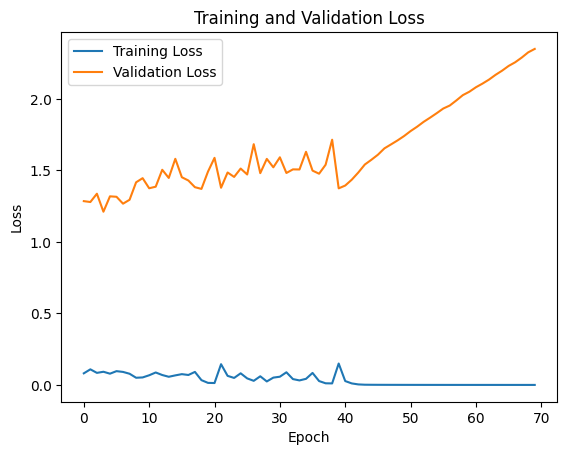

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and stored the history object
history = model.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have your test data and true labels stored in test_data and true_labels respectively

# Assuming you have already compiled and trained your model and you have predictions stored in predicted_labels
# If not, you need to make predictions on your test data
predicted_labels = model.predict(X_test)

# Convert predicted labels to class indices (assuming one-hot encoded labels)
predicted_indices = np.argmax(predicted_labels, axis=1)

# Convert true labels to class indices (assuming one-hot encoded labels)
true_indices = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_indices, predicted_indices)

print("Confusion Matrix:")
print(conf_matrix)

90/90 [==============================] - 1s 3ms/step
Confusion Matrix:
[[567  17   3   6   0]
 [ 18 362 144   5  39]
 [ 11 167 347  12  33]
 [  7   5  12 440 101]
 [  0  27  23 105 424]]


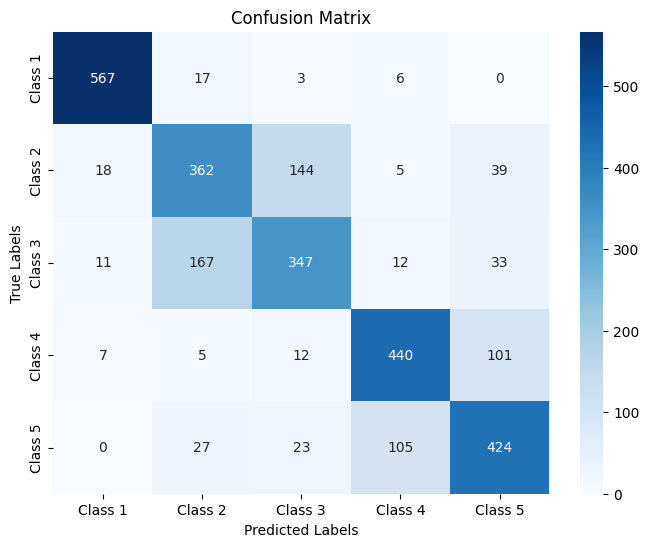

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already computed the confusion matrix as described in the previous code snippet

# Define class labels
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.evaluate(X_test,y_test)

90/90 [==============================] - 0s 3ms/step - loss: 2.3499 - accuracy: 0.7443


[2.349926233291626, 0.7443478107452393]